Modeling For Crypto Headlines:
--
Now, in this notebook I'll do some modeling to determine how well the headlines can help predict price movement in the crypto market.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.pipeline import Pipeline

import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier 
from sklearn.metrics import accuracy_score, roc_curve, auc, confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score
from sklearn import tree

from sklearn.datasets import make_classification
from sklearn.metrics import plot_confusion_matrix
import statsmodels.discrete.discrete_model as sm

from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer

import xgboost as xgb
from xgboost import plot_tree
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
df = pd.read_csv('df_ready.csv')

In [3]:
# Need the target variable in 0 and 1 format, instead of as words

df['price_move'] = df['price_direction'].apply(lambda x: 1 if x == 'up' else 0)

In [4]:
df.dtypes

v2_headline        object
period_start       object
price_direction    object
price_move          int64
dtype: object

In [5]:
df = df.drop('price_direction', axis=1)

In [6]:
df.v2_headline = df.v2_headline.astype('U')

In [7]:
X = df.v2_headline
y = df.price_move

Train-Test Splitting:
--

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

vectorizer = CountVectorizer()
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

X_train = pd.DataFrame(X_train.todense(), columns=vectorizer.get_feature_names())
X_test = pd.DataFrame(X_test.todense(), columns=vectorizer.get_feature_names())

In [64]:
X_train

,abound,abra,accelerated,accept,acceptance,accepting,accepts,accident,accidents,accounts,...,yearly,years,yes,yet,yield,yields,youtube,ytd,zero,zuckerberg
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
619,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
620,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
621,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
622,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Baseline Model Performance:
--

In [15]:
dummy_clf = DummyClassifier(strategy = 'stratified')
dummy_clf.fit(X_train, y_train)

DummyClassifier(strategy='stratified')

In [16]:
dum_predictor = dummy_clf.predict(X_test)

In [17]:
dummy_clf.score(X_train, y_train)

0.48717948717948717

Function For Confusion Matrix:
--

In [18]:
def scoring(train, pred):
    
    accuracy = accuracy_score(train, pred)
    f1 = f1_score(train, pred)
    precision = precision_score(train, pred)
    recall = recall_score(train, pred)
    
    print(f'Accuracy score is: {accuracy}')
    print('---')
    print(f'F1 score is: {f1}')
    print(f'Precision score is: {precision}')
    print(f'Recall score is: {recall}')

In [19]:
scoring(y_test, dum_predictor)

Accuracy score is: 0.5256410256410257
---
F1 score is: 0.5487804878048781
Precision score is: 0.5844155844155844
Recall score is: 0.5172413793103449


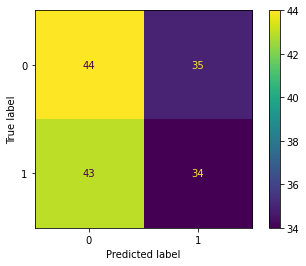

In [20]:
plot_confusion_matrix(dummy_clf, y_test, dum_predictor)  
plt.show()

Baseline Model: Logistic Regression
--

Using 'liblinear' because the dataset is quite small

In [21]:
log_reg = LogisticRegression(fit_intercept=False, C=1e12, solver='liblinear')
model_log = log_reg.fit(X_train, y_train)
model_log

LogisticRegression(C=1000000000000.0, fit_intercept=False, solver='liblinear')

In [22]:
log_test_preds = log_reg.predict(X_test)

In [23]:
scoring(y_test, log_test_preds)

Accuracy score is: 0.5448717948717948
---
F1 score is: 0.5477707006369427
Precision score is: 0.6142857142857143
Recall score is: 0.4942528735632184


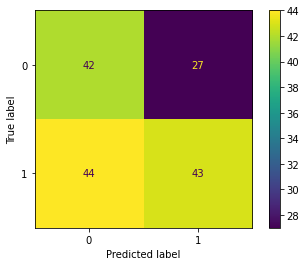

In [29]:
plot_confusion_matrix(log_reg, X_test, y_test)  
plt.show()

Random Forest: For Modeling & Feature Importance Discovery
--

In [35]:
forest = RandomForestClassifier(n_estimators=100)
forest_model = forest.fit(X_train, y_train)

In [31]:
forest_preds = forest_model.predict(X_test)

In [32]:
scoring(y_test, forest_preds)

Accuracy score is: 0.5064102564102564
---
F1 score is: 0.45390070921985815
Precision score is: 0.5925925925925926
Recall score is: 0.367816091954023


<AxesSubplot:>

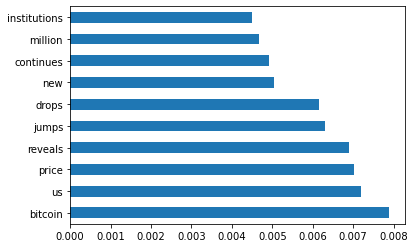

In [33]:
feat_impo = pd.Series(forest.feature_importances_, index=X_train.columns)
feat_impo.nlargest(10).plot(kind='barh')

Tuning The Number of Trees: 
--
Reducing to 25 estimators

In [45]:
forest25 = RandomForestClassifier(n_estimators=25)
forest_model25 = forest25.fit(X_train, y_train)

In [46]:
forest_preds25 = forest_model25.predict(X_test)

In [47]:
scoring(y_test, forest_preds25)

Accuracy score is: 0.5064102564102564
---
F1 score is: 0.5157232704402515
Precision score is: 0.5694444444444444
Recall score is: 0.47126436781609193


<AxesSubplot:>

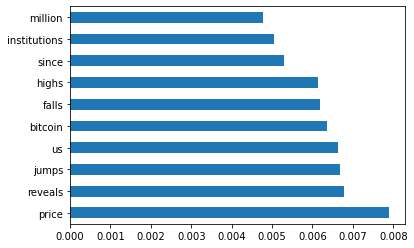

In [48]:
feat_impo25 = pd.Series(forest25.feature_importances_, index=X_train.columns)
feat_impo25.nlargest(10).plot(kind='barh')

Tuning Number of Trees:
--
Increasing the estimator number to 200

In [49]:
forest200 = RandomForestClassifier(n_estimators=200)
forest_model200 = forest200.fit(X_train, y_train)

In [50]:
forest_preds200 = forest_model200.predict(X_test)

In [51]:
scoring(y_test, forest_preds200)

Accuracy score is: 0.5128205128205128
---
F1 score is: 0.4794520547945205
Precision score is: 0.5932203389830508
Recall score is: 0.40229885057471265


<AxesSubplot:>

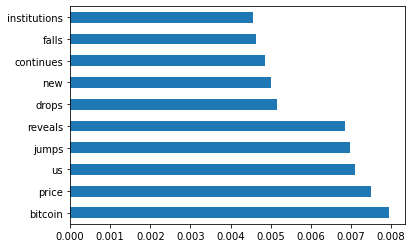

In [52]:
feat_impo200 = pd.Series(forest200.feature_importances_, index=X_train.columns)
feat_impo200.nlargest(10).plot(kind='barh')

Words "Bitcoin" and "Price":
--
These two words are 1-2 respectively in terms of importance, remain so as estimators increase and seem to distance themselves from other words. But, this doesn't seem to make the model any more precise.

Will increase estimators again to check for whether this is the makings of a pattern

In [53]:
forest500 = RandomForestClassifier(n_estimators=500)
forest_model500 = forest500.fit(X_train, y_train)

In [54]:
forest_preds500 = forest_model500.predict(X_test)

In [55]:
scoring(y_test, forest_preds500)

Accuracy score is: 0.47435897435897434
---
F1 score is: 0.4225352112676057
Precision score is: 0.5454545454545454
Recall score is: 0.3448275862068966


Reduction in Scoring with Increase in Estimators to 500
--
By checking this, it doesn't appear for now that more trees equates to better scoring, and the ability to predict so far isn't much better than guessing.

XGBoost: To Optimize The "Decision Trees" Angle
--
Now, I'll use XGBoost.

In [56]:
xgb_clf = xgb.XGBClassifier()

In [57]:
xgb_clf_model = xgb_clf.fit(X_train, y_train)

In [58]:
xgb_preds = xgb_clf.predict(X_test)

In [59]:
scoring(y_test, xgb_preds)

Accuracy score is: 0.4935897435897436
---
F1 score is: 0.3779527559055118
Precision score is: 0.6
Recall score is: 0.27586206896551724


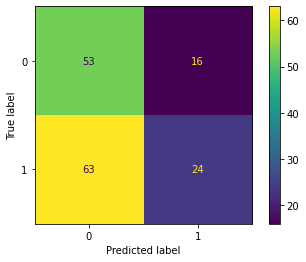

In [60]:
plot_confusion_matrix(xgb_clf_model, X_test, y_test)  
plt.show()

Logistic Regression Outperforms XGBoost
--
So far, Log-Reg produces the best Precision score while also maintaining the best Recall and F1 scores.

Returning Back to CountVectorizer: Parameter Tuning
--
Now, I'll go back to the Count Vectorizer step, to change how many vectors are included. Perhaps this will improve the Precision score (as well as other important scores)

In [62]:
X2 = df.v2_headline
y2 = df.price_move

In [65]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.2)

vectorizer2 = CountVectorizer(max_features=500)
X_train2 = vectorizer2.fit_transform(X_train2)
X_test2 = vectorizer2.transform(X_test2)

X_train2 = pd.DataFrame(X_train2.todense(), columns=vectorizer2.get_feature_names())
X_test2 = pd.DataFrame(X_test2.todense(), columns=vectorizer2.get_feature_names())

In [66]:
X_train2

,accept,accepting,accepts,across,add,adds,adoption,ahead,aim,almost,...,whales,works,world,worth,wrong,xlm,xrp,year,yearly,yet
0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
619,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
620,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
621,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
622,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [67]:
dummy_clf2 = DummyClassifier(strategy = 'stratified')
dummy_clf2.fit(X_train2, y_train2)

DummyClassifier(strategy='stratified')

In [68]:
dum_predictor2 = dummy_clf2.predict(X_test2)

In [69]:
dummy_clf2.score(X_train2, y_train2)

0.5064102564102564

In [71]:
scoring(y_test2, dum_predictor2)

Accuracy score is: 0.5833333333333334
---
F1 score is: 0.5962732919254659
Precision score is: 0.6486486486486487
Recall score is: 0.5517241379310345


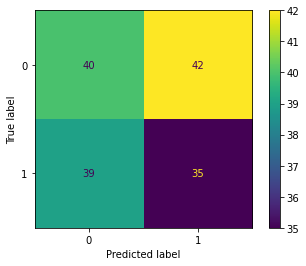

In [72]:
plot_confusion_matrix(dummy_clf2, y_test2, dum_predictor2)  
plt.show()

In [73]:
log_reg2 = LogisticRegression(fit_intercept=False, C=1e12, solver='liblinear')
model_log2 = log_reg2.fit(X_train2, y_train2)
model_log2

LogisticRegression(C=1000000000000.0, fit_intercept=False, solver='liblinear')

In [74]:
log_test_preds2 = log_reg2.predict(X_test2)

In [415]:
scoring(y_test2, log_test_preds2)

Accuracy score is: 0.4358974358974359
---
F1 score is: 0.4942528735632184
Precision score is: 0.4942528735632184
Recall score is: 0.4942528735632184


Why Does The Model Performance Worsen???
--
The Logistic Regression model was best before with more Vectors. Now, it's performing worse than the dummmy classifier. Perhaps it's a matter of just having less data to work with? 

Running Random Forest Model:
--
Let's see if the same is true of Random Forest.

In [422]:
forest_too = RandomForestClassifier(n_estimators=100)
forest_model_too = forest_too.fit(X_train2, y_train2)

In [423]:
forest_preds_too = forest_model_too.predict(X_test2)

In [424]:
scoring(y_test2, forest_preds_too)

Accuracy score is: 0.46153846153846156
---
F1 score is: 0.4324324324324324
Precision score is: 0.5245901639344263
Recall score is: 0.367816091954023


Now To Try XGBoost:
--
Before, XGBoost was worse than RF and LogR. What will be revealed now?

In [445]:
xgb_clf2 = xgb.XGBClassifier(max_depth=100)

In [446]:
xgb_clf_model2 = xgb_clf2.fit(X_train2, y_train2)

In [447]:
xgb_preds2 = xgb_clf2.predict(X_test2)

In [448]:
scoring(y_test2, xgb_preds2)

Accuracy score is: 0.5384615384615384
---
F1 score is: 0.5443037974683544
Precision score is: 0.6056338028169014
Recall score is: 0.4942528735632184


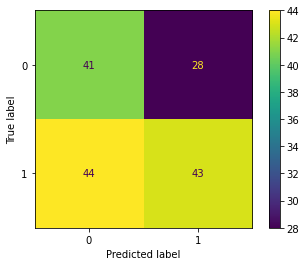

In [449]:
plot_confusion_matrix(xgb_clf_model2, X_test2, y_test2)  
plt.show()

In [450]:
xgb_clf3 = xgb.XGBClassifier(learning_rate=1, max_depth=100, min_child_weight=3, gamma=0)

In [451]:
xgb_clf_model3 = xgb_clf3.fit(X_train2, y_train2)

In [452]:
xgb_preds3 = xgb_clf3.predict(X_test2)

In [453]:
scoring(y_test2, xgb_preds3)

Accuracy score is: 0.5641025641025641
---
F1 score is: 0.5142857142857142
Precision score is: 0.6792452830188679
Recall score is: 0.41379310344827586


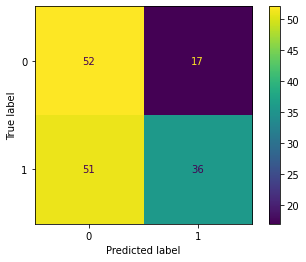

In [454]:
plot_confusion_matrix(xgb_clf_model3, X_test2, y_test2)  
plt.show()

With Some Parameter Tuning, Still Not Much Better than Guessing
--
So far, modeling on the vectors from the headlines are not showing much predictability beyond a simple guess.

3rd Train-Test Split: Reducing Vectors Further
--
Because the best method so far has been vector reduction, I will now reduce vectors further to determine whether this improves model performance.

In [342]:
X_third = df.v2_headline
y_third = df.price_move

In [455]:
X_train_third, X_test_third, y_train_third, y_test_third = train_test_split(X_third, y_third, test_size=0.2)

vectorizer_third = CountVectorizer(max_features=250)
X_train_third = vectorizer_third.fit_transform(X_train_third)
X_test_third = vectorizer_third.transform(X_test_third)

X_train_third = pd.DataFrame(X_train_third.todense(), columns=vectorizer_third.get_feature_names())
X_test_third = pd.DataFrame(X_test_third.todense(), columns=vectorizer_third.get_feature_names())

Dummy Classifier: Third Time
--
Since so far, the dummy classifier has performed better than my models even in many cases, I'll establish a baseline again.

In [456]:
dummy_clf_third = DummyClassifier(strategy = 'stratified')
dummy_clf_third.fit(X_train_third, y_train_third)

DummyClassifier(strategy='stratified')

In [457]:
dum_predictor_third = dummy_clf_third.predict(X_test_third)

In [458]:
scoring(y_test_third, dum_predictor_third)

Accuracy score is: 0.46794871794871795
---
F1 score is: 0.45751633986928103
Precision score is: 0.44871794871794873
Recall score is: 0.4666666666666667


In [459]:
log_reg_third = LogisticRegression(fit_intercept=False, C=1e12, solver='liblinear')
model_log_third = log_reg_third.fit(X_train_third, y_train_third)
model_log_third

LogisticRegression(C=1000000000000.0, fit_intercept=False, solver='liblinear')

In [460]:
log_test_preds_third = log_reg_third.predict(X_test_third)

In [461]:
scoring(y_test_third, log_test_preds_third)

Accuracy score is: 0.5384615384615384
---
F1 score is: 0.46268656716417916
Precision score is: 0.5254237288135594
Recall score is: 0.41333333333333333


In [566]:
xgb_clf_third = xgb.XGBClassifier(learning_rate=1, max_depth=50, min_child_weight=1, gamma=0)

In [567]:
xgb_clf_model_third = xgb_clf_third.fit(X_train_third, y_train_third)

In [568]:
xgb_preds_third = xgb_clf_third.predict(X_test_third)

In [569]:
scoring(y_test_third, xgb_preds_third)

Accuracy score is: 0.5705128205128205
---
F1 score is: 0.524822695035461
Precision score is: 0.5606060606060606
Recall score is: 0.49333333333333335


Trying SVM
--


In [570]:
from sklearn import svm

In [582]:
clf = svm.SVC()
clf.fit(X_train2, y_train2)

SVC()

In [583]:
svm_pred = clf.predict(X_test2)

In [584]:
scoring(y_test2, svm_pred)

Accuracy score is: 0.5128205128205128
---
F1 score is: 0.5128205128205129
Precision score is: 0.5797101449275363
Recall score is: 0.45977011494252873


In [ ]:
# taking one of ensemble models and doing a gridsearch on it -- pick 1 
# repetitive code, change to function
# Take a look at feature importances for final model
# for the top features, find out whether they occur more in positive or negative -- can be definitive
# EDA with pos-neg + up-down TargVar to visualize conclusion as well as top features

GridSearch with XGBoost:
--

In [ ]:
# new train test split
X_train_gs, X_test_gs, y_train_gs, y_test_gs = train_test_split(X, y, test_size=0.2)

In [ ]:
modelo = xgb.XGBClassifier()

pipeline = Pipeline([
    ('count_vectorizer', CountVectorizer())
    ('model', modelo)
])

param_grid = {
    'modelo__max_depth': [2, 3, 5, 7, 10],
    'modelo__n_estimators': [10, 100, 500],
    'learning_rate': [0.5, 0.8, 1, 1.5],
    'min_child_weight': [1, 3, 5, 7, 10]
}

grid = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1, scoring='precision')

In [ ]:
grid.fit(X_train_gs, y_train_gs)

In [ ]:
grid.best_params